In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Explore

In [2]:
with open('data/train.json') as data:
  dishes = pd.read_json(data)

In [3]:
print("There are {0} total recipes.".format(len(dishes['id'].unique())))
dishes.head()

There are 39774 total recipes.


id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

In [4]:
print("There are {0} total cuisines available.".format(len(dishes['cuisine'].unique())))
dishes['cuisine'].value_counts()

There are 20 total cuisines available.


italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [5]:
# Explode function in pandas 0.25
dishes = dishes.explode('ingredients')

print("There are {0} total unique ingredients.".format(len(dishes['ingredients'].unique())))
dishes.head()

There are 6714 total unique ingredients.


id cuisine      ingredients
0  10259   greek  romaine lettuce
0  10259   greek     black olives
0  10259   greek   grape tomatoes
0  10259   greek           garlic
0  10259   greek           pepper

In [6]:
def hbar_top_facet_grid(df, label, value, group, color='b'):
    # Get only top 5
    data = df.sort_values([group, value], ascending=False).groupby(group).head(5)

    # To view all styles: plt.style.available
    sns.set(style="white", font_scale = 1.9)

    # https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access
    g = sns.FacetGrid(data.sort_values([group, value]), col=group, col_wrap=4, sharey=False, sharex=False, 
                      height=4, aspect=1.5)

    g = g.map(plt.barh, label, value, color=color)
    g = g.set_titles(col_template="{col_name}", size=24)
    g = g.set_xlabels(' ')
    g = g.set_ylabels(' ')

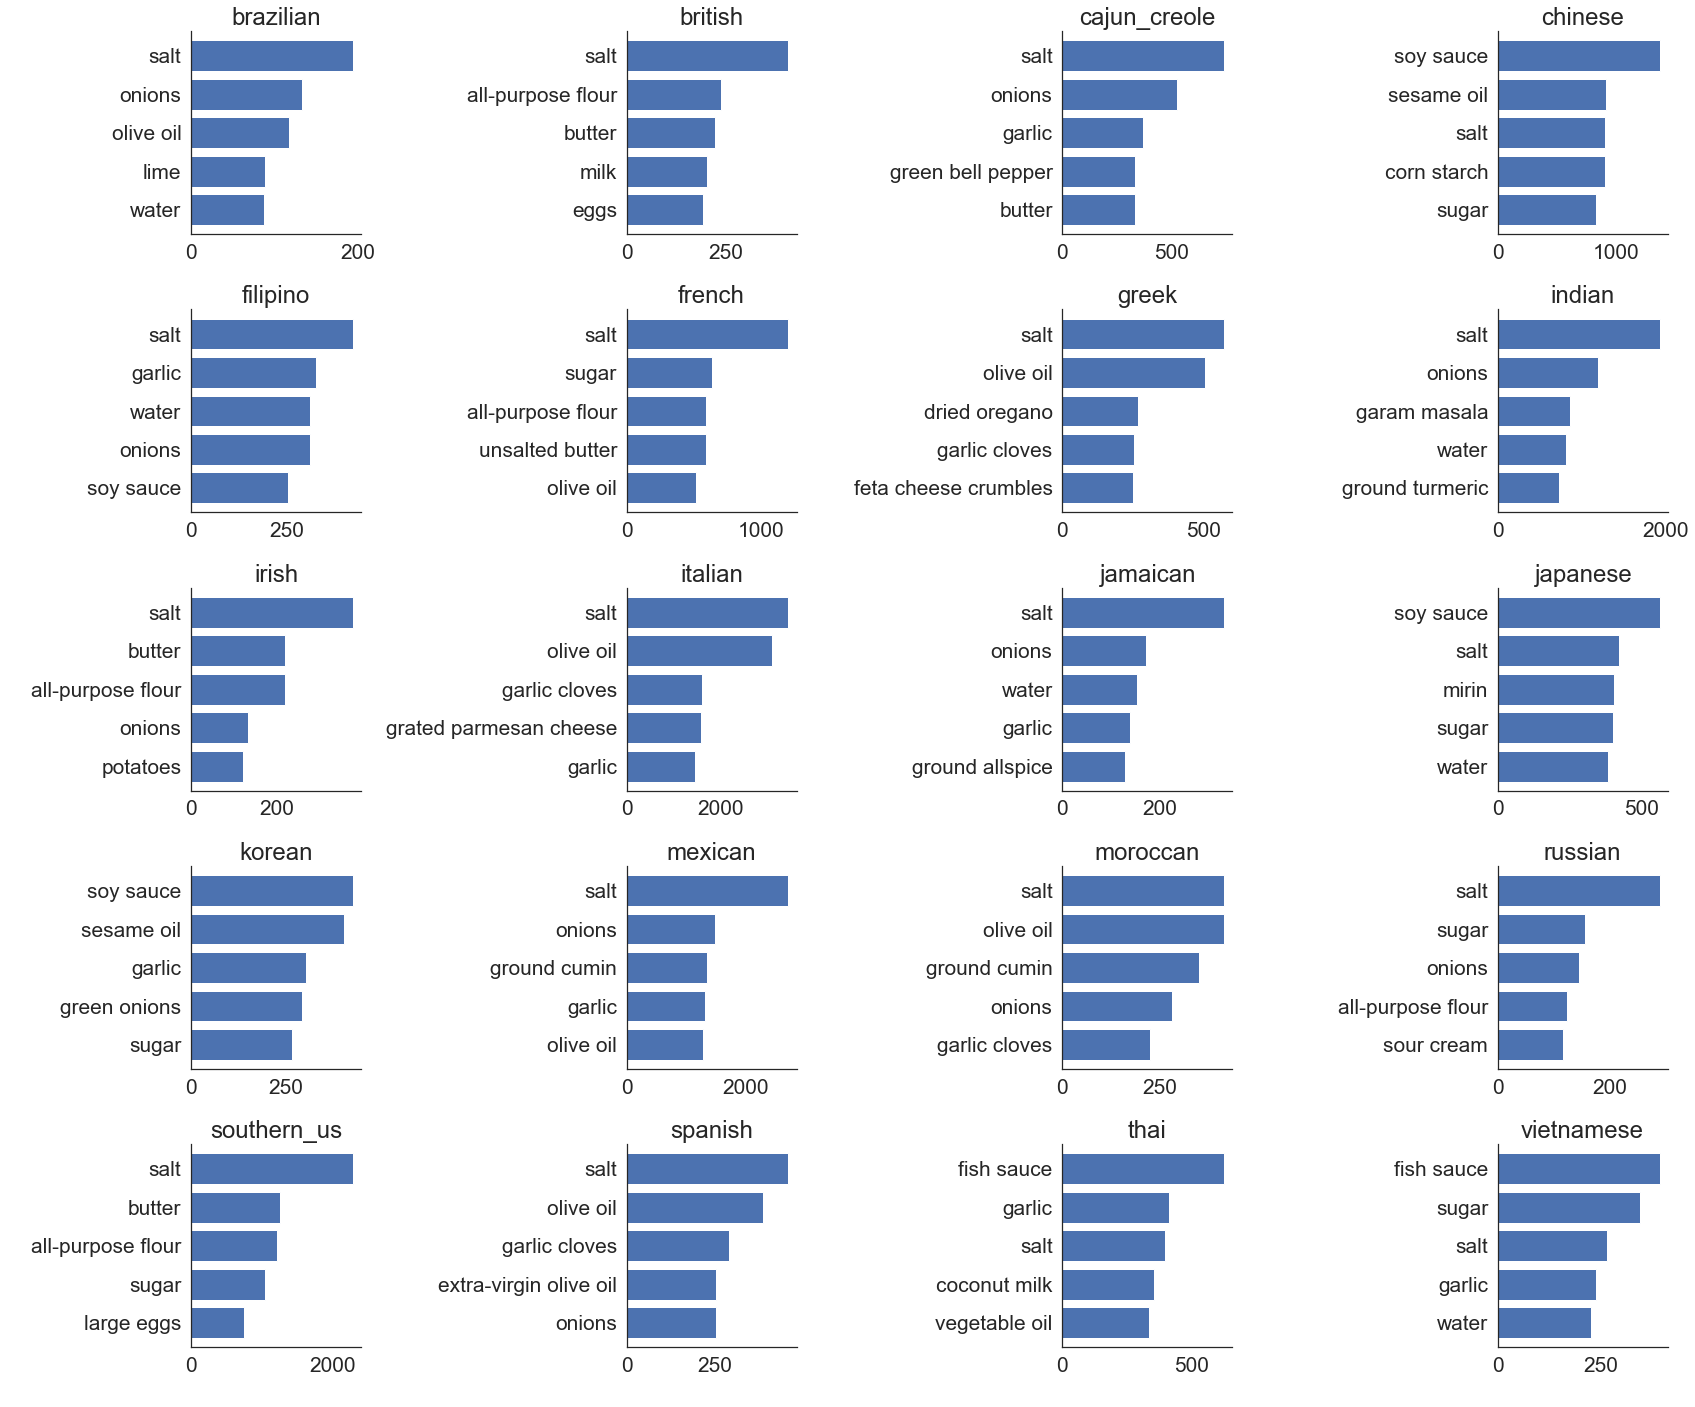

In [7]:
# group by ingredient - cuisine
data = pd.DataFrame(dishes.groupby(['cuisine', 'ingredients']).size().reset_index(name='count'))

hbar_top_facet_grid(data, 'ingredients', 'count', 'cuisine')

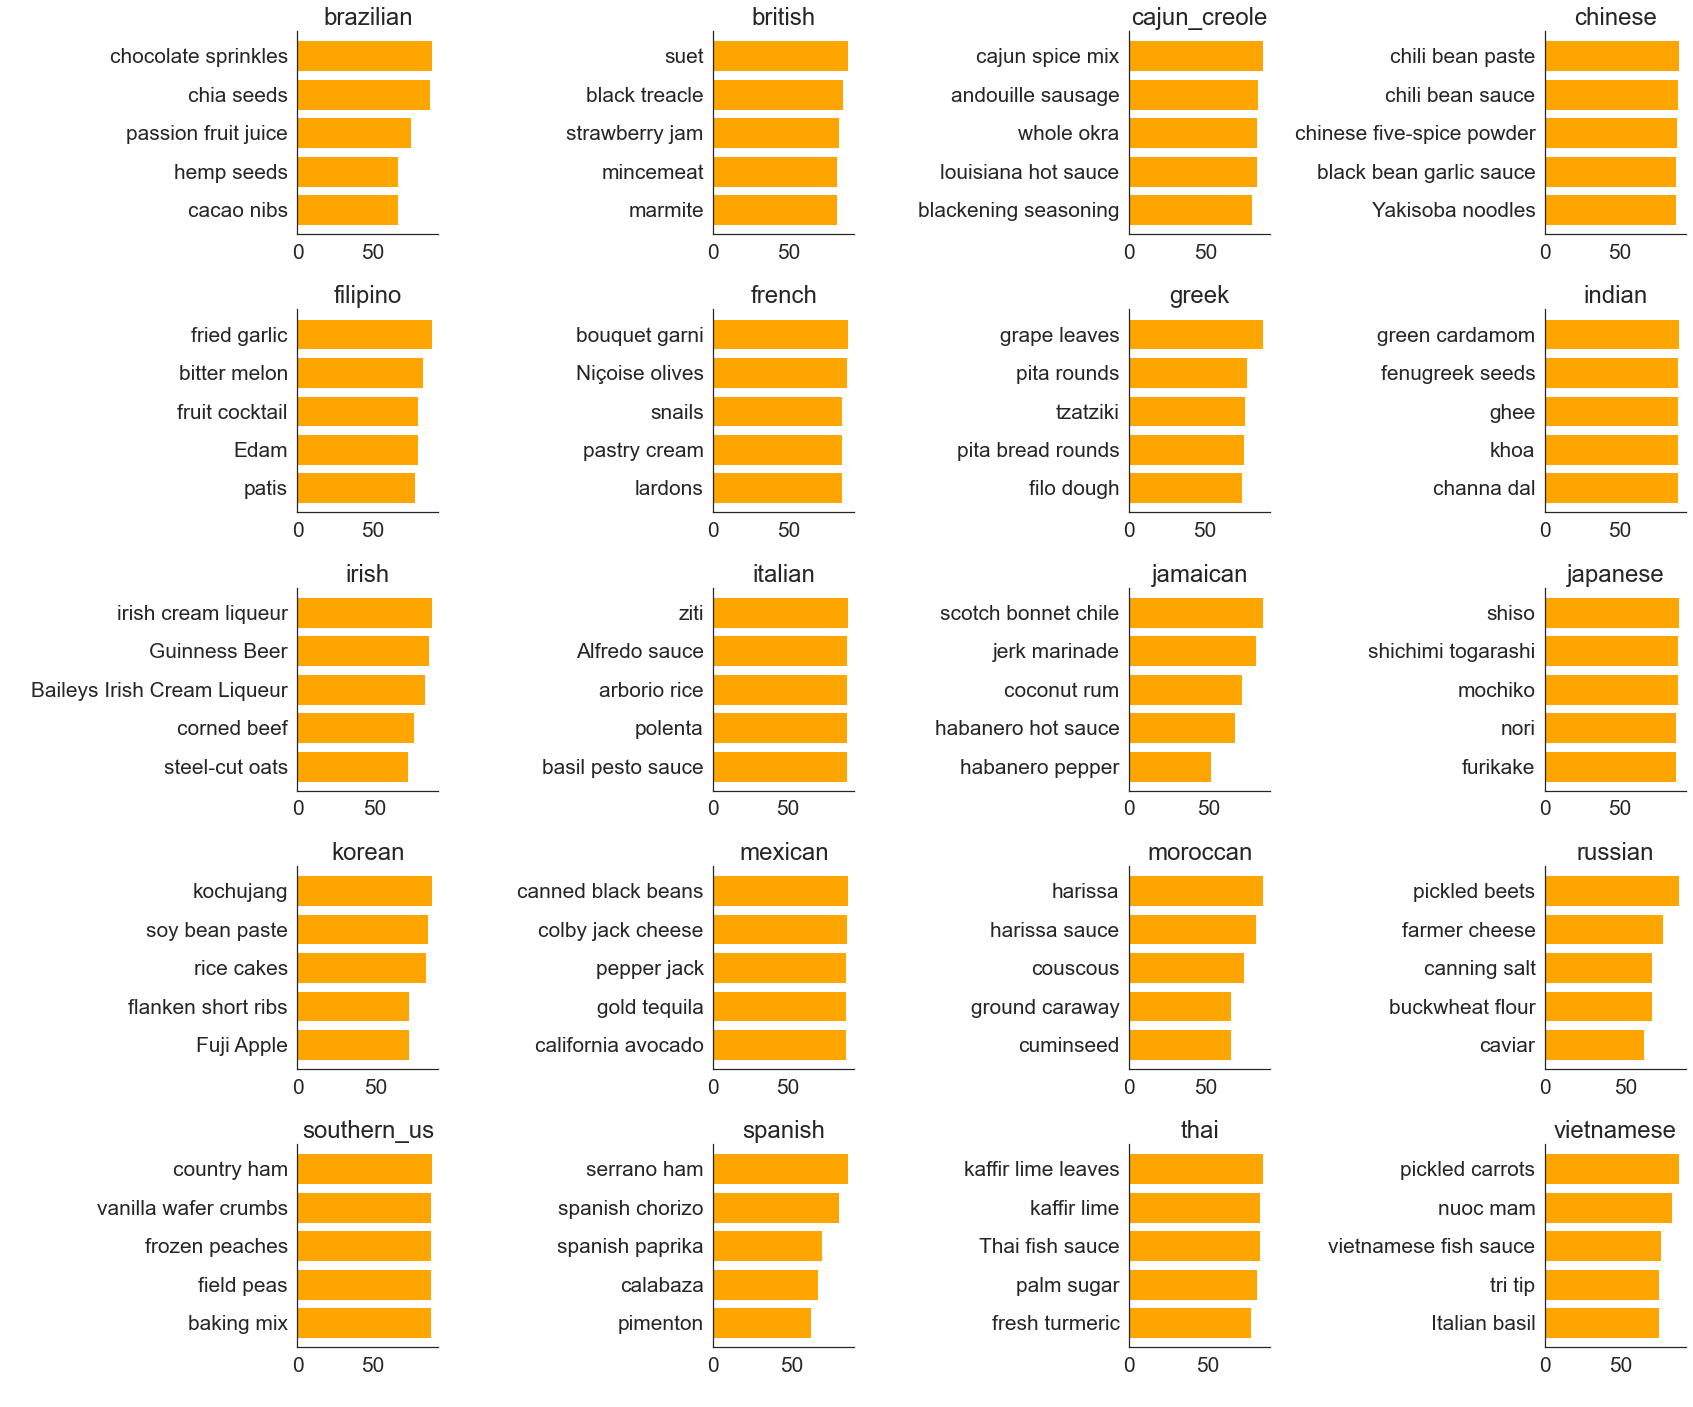

In [8]:
# How frequent is a specific cuisine ingredient used among all cuisines?
# we take advantage of groupby index from 
# https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
data = pd.DataFrame(dishes.groupby(['ingredients', 'cuisine']).size() / 
                    dishes.groupby('ingredients').size()).reset_index()
data.columns = ['ingredients', 'cuisine', 'relative_usage']
data['relative_usage'] = data['relative_usage']*100

# Still not quite right, some ingredients are only used once or twice, so they have x/x = 1 -> close to 100% usage
# to know the bins: data['relative_usage'].value_counts(bins=10)
# two options: 
# 1) keep ingredients appear in at least 10% of all recipes
# frequent = pd.DataFrame(dishes['ingredients'].value_counts(normalize=True).reset_index(name='density'))
# frequent_list = frequent[frequent['density'] >= .00001]['index'].tolist()
# data = data[data['ingredients'].isin(frequent_list)]

# 2) exclude relative usage < 90% - the top rarest
data = data[data['relative_usage'] < 90]

# redraw
hbar_top_facet_grid(data, 'ingredients', 'relative_usage', 'cuisine', color='orange')

Much more interesting!

## Food Network

In [9]:
import json
import itertools
import networkx as nx

In [10]:
with open('data/train.json') as data:
  dishes_json = json.load(data)

In [11]:
def get_combinations(l):
    '''input list of items and output all pair edges'''
    g = []
    for i in itertools.combinations(l ,2): #get all combos
        g.append(i)
    return g

def get_cuisine_top_ingr(pct):
    '''get dict of ingredients appear in at least {pct} of EACH cuisine '''
    data = (dishes.groupby(['cuisine', 'ingredients']).size() / 
                dishes.groupby(['cuisine']).size()).reset_index(name='pct') #get pct
    top_ingr = data[data['pct'] > pct] #filter

    top_ingr_dict = {}
    for key, g in top_ingr.groupby('cuisine'):
        top_ingr_dict[key] = g['ingredients'].tolist()
    return top_ingr_dict
    
def filter_node_df(df, top_ingr):
    '''filter node df by top ingredient dict'''
    dfs = []
    for key, g in df.groupby('cuisine'):
        dfs.append(g[g['ingredients'].isin(top_ingr[key])])
    
    df = pd.concat(dfs)
    print("Nodes: {0}".format(df.shape[0]))
    return df

def filter_edge_df(df, top_ingr):
    '''filter edge df by top ingredient dict'''
    dfs = []
    for key, g in df.groupby('cuisine'):
        dfs.append(g[g['source'].isin(top_ingr[key]) & g['target'].isin(top_ingr[key])])
    
    df = pd.concat(dfs)    
    print("Edges: {0}".format(df.shape[0]))
    return df

def draw_network(n, e):    
    G = nx.from_pandas_edgelist(e, 'source', 'target')
    nx.draw(G, with_labels=True, node_color="skyblue", pos=nx.random_layout(G), node_size=n['size'])
    plt.show()

In [12]:
# Get edge df
new_dict = [] #start with dict
for dish in dishes_json:
    edges_list = get_combinations(dish['ingredients'])
    for edges in edges_list:
        new_dict.append({'id':dish['id'], 'cuisine':dish['cuisine'], 'source': edges[0], 'target': edges[1]})
        
edge_df = pd.DataFrame.from_dict(new_dict).groupby(['source', 'target', 'cuisine']).size().reset_index(name='count')

In [13]:
# Get node df
node_df = dishes.groupby(['cuisine', 'ingredients']).size().reset_index(name='size')

print("Nodes: {0}".format(node_df.shape[0])) #too many nodes + edges
print("Edges: {0}".format(edge_df.shape[0]))

Nodes: 29179
Edges: 1045934


In [16]:
# Filter
node_df = filter_node_df(node_df, get_cuisine_top_ingr(0.007)) #at least 0.7%
edge_df = filter_edge_df(edge_df, get_cuisine_top_ingr(0.007))

Nodes: 496
Edges: 11723


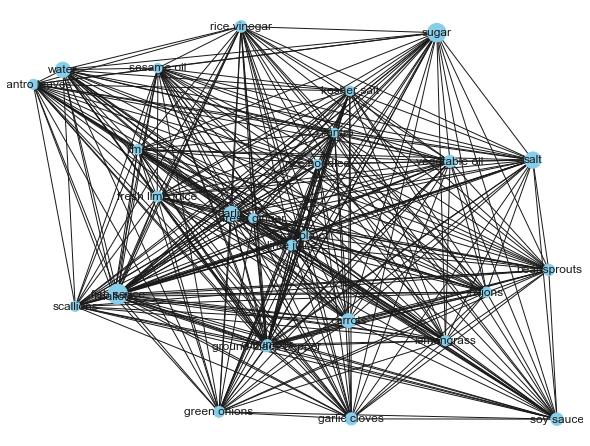

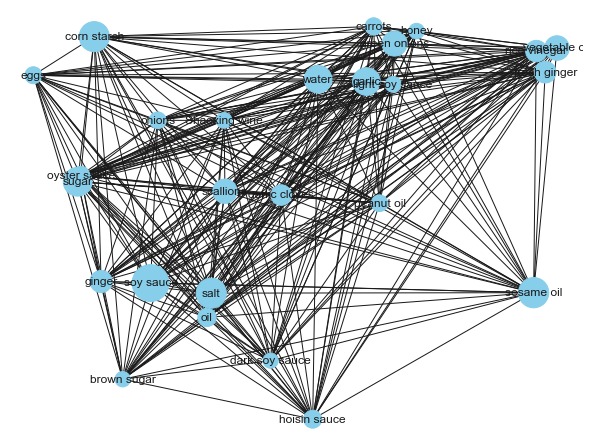

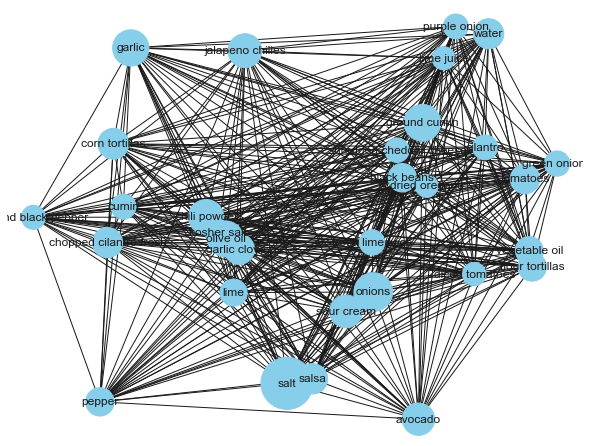

In [17]:
# Draw plt networkx
for cuisine in ['vietnamese', 'chinese', 'mexican']:
    n = node_df[node_df['cuisine'] == cuisine]
    e = edge_df[edge_df['cuisine'] == cuisine]
    
    plt.rcParams['figure.figsize'] = (8, 6) #set figsize for all
    draw_network(n, e)

## Plotly

In [29]:
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)

In [ ]:
def get_pos_dict(c):
    

In [36]:
n = node_df[node_df['cuisine'] == 'vietnamese']
e = edge_df[edge_df['cuisine'] == 'vietnamese']
G = nx.from_pandas_edgelist(e, 'source', 'target')
pos = nx.spring_layout(G)   

In [49]:
# Assign pos
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = (pos[edge[0]][0], pos[edge[0]][1])
    x1, y1 = (pos[edge[1]][0], pos[edge[1]][1])

    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node][0], pos[node][1]
    node_x.append(x)
    node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

In [52]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [53]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()